In [1]:
import sys
import os

import numpy as np
from process_bigraph import Composite
from process_bigraph.experiments.parameter_scan import RunProcess


sys.path.insert(0, '..')


from biosimulator_processes.processes.amici_process import AmiciUTC
from biosimulator_processes.io import read_report_outputs
from biosimulator_processes.utils import plot_utc_outputs

Available processes:
[ 'console-emitter',
  'ram-emitter',
  'composite',
  'cobra',
  'copasi',
  'tellurium',
  'amici']
Available processes:
[ 'console-emitter',
  'ram-emitter',
  'composite',
  'cobra',
  'copasi',
  'tellurium',
  'amici',
  'copasi-step',
  'tellurium-step',
  'amici-step',
  'plotter',
  'plotter2d']


In [2]:
omex_dir = './examples/sbml-core/Elowitz-Nature-2000-Repressilator'
reports_path = os.path.join(omex_dir, 'reports.h5')

In [3]:
amici_process = AmiciUTC(
    config={
        'model': {
            'model_source': omex_dir
        }
    }
)

2024-05-29 12:14:41.892 - amici.sbml_import - INFO - Finished importing SBML                         (4.33E-02s)
2024-05-29 12:14:41.939 - amici.sbml_import - INFO - Finished processing SBML observables            (4.39E-02s)
2024-05-29 12:14:41.944 - amici.sbml_import - INFO - Finished processing SBML event observables      (5.41E-07s)
2024-05-29 12:14:41.969 - amici.de_model - INFO - Finished computing xdot                            (3.66E-03s)
2024-05-29 12:14:41.976 - amici.de_model - INFO - Finished computing x0                              (3.72E-03s)
2024-05-29 12:14:41.995 - amici.de_model - INFO - Finished computing w                               (1.55E-02s)
2024-05-29 12:14:42.746 - amici.de_export - INFO - Finished generating cpp code                      (7.45E-01s)
2024-05-29 12:14:51.840 - amici.de_export - INFO - Finished compiling cpp code                       (9.09E+00s)


In [4]:
# t range parameters set via sedml introspection within archive contents:
amici_process.t[0], amici_process.t[-1], amici_process.duration, amici_process.step_size, amici_process.num_steps

(400.0, 600.0, 600, 1.0, 600)

In [5]:
!cat ./examples/sbml-core/Elowitz-Nature-2000-Repressilator/simulation.sedml

<?xml version="1.0" encoding="UTF-8"?>
<sedML xmlns="http://sed-ml.org/sed-ml/level1/version3" level="1" version="3"
  xmlns:sbml="http://www.sbml.org/sbml/level2/version3">
  <listOfModels>
    <model id="model" language="urn:sedml:language:sbml" source="BIOMD0000000012_url.xml">
      <listOfChanges>
        <changeAttribute target="/sbml:sbml/sbml:model/sbml:listOfSpecies/sbml:species[@id='PX']/@initialAmount" newValue="0"/>
      </listOfChanges>
    </model>
  </listOfModels>
  <listOfSimulations>
    <uniformTimeCourse id="simulation" initialTime="0" outputStartTime="400" outputEndTime="1000" numberOfPoints="600">
      <algorithm kisaoID="KISAO:0000019"/>
    </uniformTimeCourse>
  </listOfSimulations>
  <listOfTasks>
    <task id="task" modelReference="model" simulationReference="simulation"/>
  </listOfTasks>
  <listOfDataGenerators>
    <dataGenerator id="data_gen_time" name="time">
      <math xmlns="http://www.w3.org/1998/Math/MathML">
        <ci> var_time </ci>
      </ma

In [6]:
amici_process_results = amici_process.update()

<Axes: >

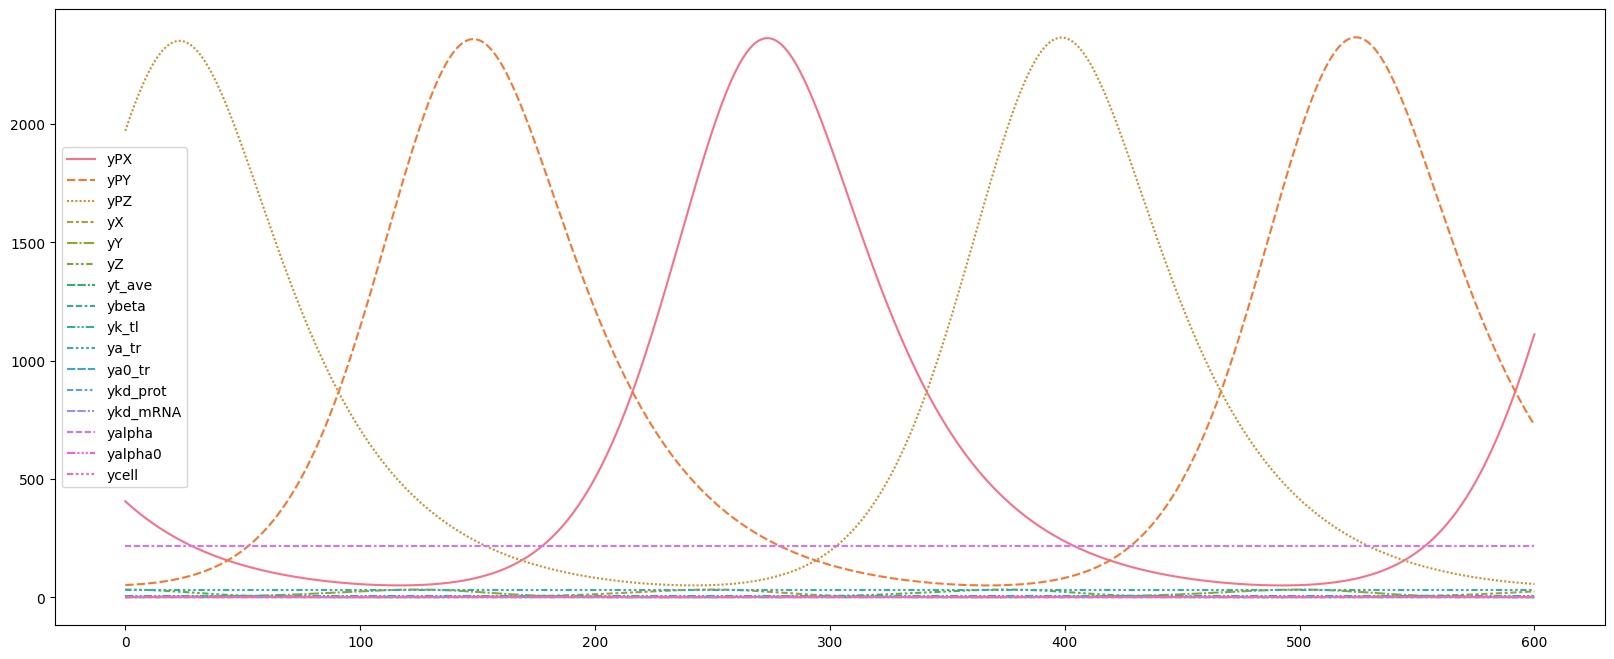

In [7]:
plot_utc_outputs(data=amici_process_results, simulator_name='Amici UTC Process Results for Repressilator')